In [1]:
%load_ext autoreload
%autoreload 2


%pylab inline

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

import numpy as np
import tqdm
import torch

from models import Discriminator, Generator
from utils import get_dataloader

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
BS = 128
img_size = 128
# Dataloader
dataloader = get_dataloader(img_size= img_size, batch_size = BS)

In [3]:
img_channel, img_size, _ = dataloader.dataset[0][0].shape
nb_channels = 64
nb_convs = 5
strides = [2] * nb_convs
kernels = [7,3,3,3,3]
mult_channels = [1,2,4,4,8]

latent_dim = 100


In [4]:
class Discriminator(nn.Module):
    def __init__(self, img_channel, img_size, nb_channels, nb_convs, strides = None, kernels = None, mult_channels = None, drop = 0.2):
        super().__init__()
        if strides is not None:
            assert len(strides) == nb_convs
            self.strides = strides
        else:
            self.strides = []
            for i in range(nb_convs):
                if img_size %2**(i+1) == 0:
                    self.strides.append(2)
                else:
                    self.strides.append(1)
        
        if kernels is not None:
            assert len(kernels) == nb_convs
            self.kernels = kernels
        else:
            self.kernels = [3] * nb_convs
        
        if mult_channels is not None:
            assert len(mult_channels) == nb_convs
            self.mult_channels = mult_channels
        else:
            self.mult_channels = [2**n for n in range(nb_convs)]
            
        self.conv_init = nn.Conv2d(img_channel, self.mult_channels[0] * nb_channels, kernel_size=self.kernels[0], stride = self.strides[0], padding = self.kernels[0]//2)
        convs_list = nn.ModuleList([])

        for i in range(1,nb_convs):
            convs_list.extend([nn.Conv2d(self.mult_channels[i-1] * nb_channels, self.mult_channels[i] * nb_channels, kernel_size=self.kernels[i], stride = self.strides[i], padding = self.kernels[i]//2),
                                    nn.BatchNorm2d(self.mult_channels[i]*nb_channels),
                                    nn.LeakyReLU(negative_slope=0.2)])
        
        self.conv_layers = nn.Sequential(*convs_list)

        self.dropout = nn.Dropout(p = drop)
        
        flatten_dim = (img_size // prod(self.strides))**2 * self.mult_channels[-1]*nb_channels

        self.head = nn.Linear(flatten_dim, 1, bias = False)
    
    def forward(self, x):
        B = x.shape[0]
        x = F.leaky_relu(self.conv_init(x), negative_slope = 0.2)
        x = self.conv_layers(x)
        x = self.dropout(x)
        x = x.reshape(B, -1)
        logits = F.sigmoid(self.head(x))
        return logits

In [5]:
class Generator(nn.Module):
    def __init__(self,latent_dim,img_channel,img_size,nb_channels,  kernels_discr, strides_discr, mult_channels_discr, output_pad = 1):
        super().__init__()
        self.latent_dim = latent_dim
        self.img_compressed = img_size//prod(strides_discr)
        self.kernels = kernels_discr[::-1]
        self.strides = strides_discr[::-1]
        self.mult_channels = mult_channels_discr[::-1]
        nb_conv = len(self.kernels)
        self.start_channels = self.mult_channels[0]*nb_channels
        self.hidden_dim = self.img_compressed**2*self.start_channels

        self.ln = nn.Linear(self.latent_dim, self.hidden_dim)

        convTs_list = nn.ModuleList([])

        for i in range(nb_conv-1):
            if self.strides[i] >1:
                convTs_list.extend([nn.ConvTranspose2d(self.mult_channels[i]*nb_channels, self.mult_channels[i+1]*nb_channels,kernel_size=self.kernels[i], stride = self.strides[i], padding = self.kernels[i]//2, output_padding=output_pad),
                                            nn.BatchNorm2d(self.mult_channels[i+1]*nb_channels),
                                            nn.ReLU()])
            else:
                convTs_list.extend([nn.ConvTranspose2d(self.mult_channels[i]*nb_channels, self.mult_channels[i+1]*nb_channels,kernel_size=self.kernels[i], stride = self.strides[i], padding = self.kernels[i]//2),
                                            nn.BatchNorm2d(self.mult_channels[i+1]*nb_channels),
                                            nn.ReLU()])

        self.convs_transpose = nn.Sequential(*convTs_list)
        self.last_convT = nn.ConvTranspose2d(self.mult_channels[-1]*nb_channels, img_channel, kernel_size= self.kernels[-1], stride = self.strides[-1], padding = self.kernels[-1]//2, output_padding=output_pad)


    def forward(self,x):
        B = x.shape[0]
        x = F.relu(self.ln(x))
        x = x.view(B, self.start_channels, self.img_compressed, self.img_compressed)

        x = self.convs_transpose(x)
        x = F.tanh(self.last_convT(x))
        return x

In [6]:
def create_fake_samples(batch_size, latent_dim, generator):
    dev = generator.ln.weight.device
    noise = torch.randn((batch_size,latent_dim)).to(dev)
    fake = generator(noise)
    fake_target = torch.zeros(batch_size,1).to(dev)
    return fake, fake_target

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


In [7]:
D = Discriminator(img_channel, img_size, nb_channels, nb_convs, strides, kernels, mult_channels)
G = Generator(latent_dim, img_channel, img_size, nb_channels,kernels, strides, mult_channels)

device = torch.device('cuda')
D = D.to(device)
G = G.to(device)
G.apply(weights_init)
D.apply(weights_init)
loss_fn = nn.BCELoss()
lr = 0.0001
optim_D = torch.optim.Adam(D.parameters(), lr = lr, betas = (0.5, 0.999))
optim_G = torch.optim.Adam(G.parameters(), lr = lr, betas = (0.5, 0.999))

In [9]:
losses_D = []
losses_G = []
epochs = 30
for _ in range(epochs):
    pbar = tqdm.tqdm(dataloader)
    for dat in pbar:
        X_real = dat[0].to(device)
        y_real = torch.ones(X_real.shape[0],1).to(device)

        X_fake, y_fake = create_fake_samples(BS,latent_dim, G)


        D.zero_grad()
        out_real = D(X_real)
        loss_D = loss_fn(out_real, y_real)
        loss_D.backward()
        optim_D.step()
        loss_totD = loss_D.item()
        
        out_fake = D(X_fake.detach())
        loss_D = loss_fn(out_fake, y_fake)
        loss_D.backward()
        optim_D.step()
        loss_totD += loss_D.item()

        losses_D.append(loss_totD)
        
        G.zero_grad()
        out_gan = D(X_fake)
        y_gan = torch.ones(BS,1).to(device)
        loss_G = loss_fn(out_gan, y_gan)
        loss_G.backward()
        optim_G.step()
        losses_G.append(loss_G.item())
        

        pbar.set_description(f'loss D: %.3f, loss G: %.3f' % (loss_totD, loss_G.item()))



    

loss D: 0.018, loss G: 7.806: 100%|██████████| 115/115 [03:50<00:00,  2.00s/it]


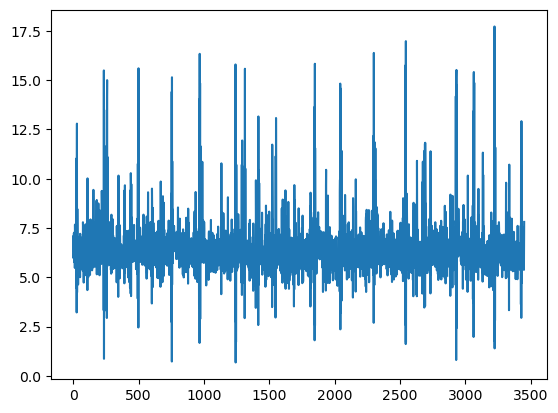

In [10]:
plot(losses_G)

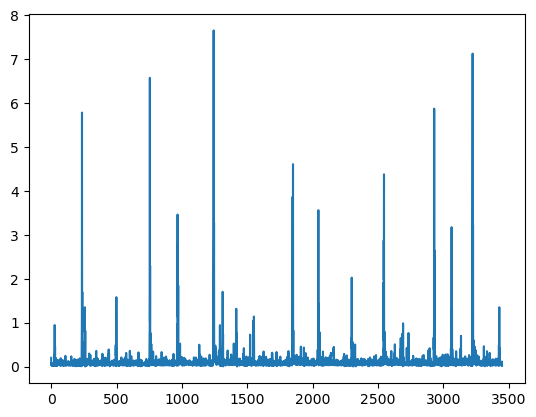

In [11]:
plot(losses_D)

In [14]:
nb_samples = 16
with torch.no_grad():
    G.eval()
    noise = torch.randn(nb_samples, latent_dim).to(device)
    samp = G(noise)

grid_samples = torchvision.utils.make_grid(samp.cpu(), nrow = int(np.sqrt(nb_samples)))
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


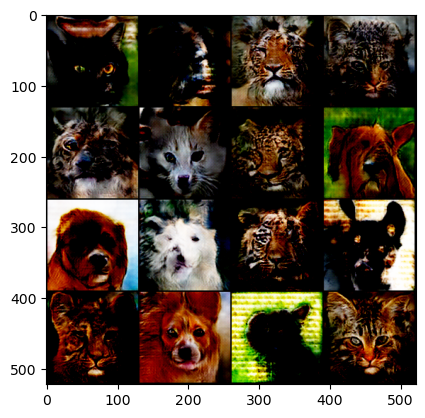

In [15]:
imshow(grid_samples.permute(1,2,0))


In [16]:
#torch.save(D.state_dict(),'.\model_saves\D_afhq_128imgsize.pth')
#torch.save(G.state_dict(),'.\model_saves\G_afhq_128imgsize.pth')

In [8]:
#D.load_state_dict(torch.load('.\model_saves\D_afhq_128imgsize.pth'))
#G.load_state_dict(torch.load('.\model_saves\G_afhq_128imgsize.pth'))

<All keys matched successfully>